Make sure you have the below packages downladed (through pip install)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states

In [2]:
with open('Census_token.txt') as f: 
    c = Census(f.read())

In [3]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# FIPS code for AZ is 04, just need to change VA to AZ in state_flips
###### ----variable website---->>> https://api.census.gov/data/2019/acs/acs1/variables.html
# B02001_003E - Estimate!!Total:!!Black or African American alone
# B02001_004E - Estimate!!Total:!!American Indian and Alaska Native alone
# B02001_005E - Estimate!!Total:!!Asian alone
# B02001_006E - Estimate!!Total:!!Native Hawaiian and Other Pacific Islander alone
# B02001_007E - Estimate!!Total:!!Some other race alone
# B03002_001E - HISPANIC OR LATINO ORIGIN BY RACE
######## ----> NOTE THERE ARE NO MIXED all are solo, but we will probably want to add that
# B01003_001E: total population
# Do not have 2021 available yet, can only run through 2020
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
az_census = c.acs5.state_county_tract(fields = ('NAME', 'B02001_003E', 'B02001_004E', 'B02001_005E', 
                                                'B02001_006E', 'B02001_007E', 'B03002_001E', 'B01003_001E'),
                                      state_fips = states.AZ.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2020)

In [4]:
# Create a dataframe from the census data
az_df = pd.DataFrame(az_census)

# Show the dataframe
print(az_df.head(2))
print('Shape: ', az_df.shape)

                                            NAME  B02001_003E  B02001_004E  \
0  Census Tract 610.44, Maricopa County, Arizona        954.0         49.0   
1  Census Tract 610.45, Maricopa County, Arizona        476.0         11.0   

   B02001_005E  B02001_006E  B02001_007E  B03002_001E  B01003_001E state  \
0        416.0         61.0        136.0       8773.0       8773.0    04   
1        125.0          0.0        302.0       7874.0       7874.0    04   

  county   tract  
0    013  061044  
1    013  061045  
Shape:  (1765, 11)


In [5]:
# Access shapefile of Virginia census tracts
az_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_04_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
az_tract = az_tract.to_crs(epsg = 32617)

# Print GeoDataFrame of shapefile
print(az_tract.head(2))
print('Shape: ', az_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(az_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
0      04      015  950500  04015950500  9505  Census Tract 9505  G5020   
1      04      015  954900  04015954900  9549  Census Tract 9549  G5020   

  FUNCSTAT       ALAND    AWATER     INTPTLAT      INTPTLON  \
0        S  1255016476  39469850  +35.3440369  -114.3629894   
1        S    22392503         0  +35.2440284  -114.0595108   

                                            geometry  
0  POLYGON ((-2605753.221 4497432.366, -2605733.2...  
1  POLYGON ((-2561412.583 4449714.181, -2561223.1...  
Shape:  (1765, 13)

The shapefile projection is: epsg:32617


In [6]:
# Combine state, county, and tract columns together to create a new string and assign to new column
az_df["GEOID"] = az_df["state"] + az_df["county"] + az_df["tract"]

In [7]:
# Print head of dataframe
az_df.head(2)

,NAME,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B03002_001E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 610.44, Maricopa County, Arizona",954.0,49.0,416.0,61.0,136.0,8773.0,8773.0,04,013,061044,04013061044
1,"Census Tract 610.45, Maricopa County, Arizona",476.0,11.0,125.0,0.0,302.0,7874.0,7874.0,04,013,061045,04013061045


In [8]:
# Remove columns
az_df = az_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
az_df.head(2)

,NAME,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B03002_001E,B01003_001E,GEOID
0,"Census Tract 610.44, Maricopa County, Arizona",954.0,49.0,416.0,61.0,136.0,8773.0,8773.0,04013061044
1,"Census Tract 610.45, Maricopa County, Arizona",476.0,11.0,125.0,0.0,302.0,7874.0,7874.0,04013061045


In [9]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(az_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(az_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas

Column data types for census data:
NAME            object
B02001_003E    float64
B02001_004E    float64
B02001_005E    float64
B02001_006E    float64
B02001_007E    float64
B03002_001E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [10]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
az_merge = az_tract.merge(az_df, on = "GEOID")

# Show result
print(az_merge.head(2))
print('Shape: ', az_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x           NAMELSAD  MTFCC  \
0      04      015  950500  04015950500   9505  Census Tract 9505  G5020   
1      04      015  954900  04015954900   9549  Census Tract 9549  G5020   

  FUNCSTAT       ALAND    AWATER  ...      INTPTLON  \
0        S  1255016476  39469850  ...  -114.3629894   
1        S    22392503         0  ...  -114.0595108   

                                            geometry  \
0  POLYGON ((-2605753.221 4497432.366, -2605733.2...   
1  POLYGON ((-2561412.583 4449714.181, -2561223.1...   

                                      NAME_y B02001_003E  B02001_004E  \
0  Census Tract 9505, Mohave County, Arizona        43.0         10.0   
1  Census Tract 9549, Mohave County, Arizona         6.0          0.0   

   B02001_005E  B02001_006E  B02001_007E  B03002_001E  B01003_001E  
0          6.0          8.0          0.0       1601.0       1601.0  
1          0.0          0.0         55.0       3662.0       3662.0  

[2 rows 

In [11]:
# Create new dataframe from select columns
az_poverty_tract = az_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", 'B02001_003E', 'B02001_004E', 'B02001_005E', 
                                                'B02001_006E', 'B02001_007E',  'B03002_001E','B01003_001E']]

# Show dataframe
print(az_poverty_tract.head(2))
print('Shape: ', az_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      04      015  950500  04015950500   
1      04      015  954900  04015954900   

                                            geometry  B02001_003E  \
0  POLYGON ((-2605753.221 4497432.366, -2605733.2...         43.0   
1  POLYGON ((-2561412.583 4449714.181, -2561223.1...          6.0   

   B02001_004E  B02001_005E  B02001_006E  B02001_007E  B03002_001E  \
0         10.0          6.0          8.0          0.0       1601.0   
1          0.0          0.0          0.0         55.0       3662.0   

   B01003_001E  
0       1601.0  
1       3662.0  
Shape:  (1765, 12)


In [12]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
az_poverty_county = az_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(az_poverty_county.head(2))
print('Shape: ', az_poverty_county.shape)

                                                   geometry  B02001_003E  \
COUNTYFP                                                                   
001       POLYGON ((-2216287.968 4138869.589, -2215413.7...        545.0   
003       POLYGON ((-2260950.710 3843083.655, -2261376.6...       5158.0   

          B02001_004E  B02001_005E  B02001_006E  B02001_007E  B03002_001E  \
COUNTYFP                                                                    
001           52565.0        262.0         55.0        759.0      71714.0   
003            1461.0       2386.0        400.0       3071.0     126442.0   

          B01003_001E  
COUNTYFP               
001           71714.0  
003          126442.0  
Shape:  (15, 8)


In [13]:
# Get poverty rate and store values in new column
########
#This is where we can change what it illustrates I think

az_poverty_county["Minority_Rate"] = (az_poverty_county['B02001_003E'] + az_poverty_county['B02001_004E'] + 
                                     az_poverty_county['B02001_005E'] + az_poverty_county['B02001_006E']
                                    + az_poverty_county['B02001_007E'] + az_poverty_county['B03002_001E']) / az_poverty_county['B01003_001E'] * 100

# Show dataframe
az_poverty_county.head(2)

,geometry,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B03002_001E,B01003_001E,Minority_Rate
COUNTYFP,,,,,,,,,
001,"POLYGON ((-2216287.968 4138869.589, -2215413.7...",545.0,52565.0,262.0,55.0,759.0,71714.0,71714.0,175.558468
003,"POLYGON ((-2260950.710 3843083.655, -2261376.6...",5158.0,1461.0,2386.0,400.0,3071.0,126442.0,126442.0,109.866975


Text(0.5, 1.0, 'Minority Rates (%) in Arizona')

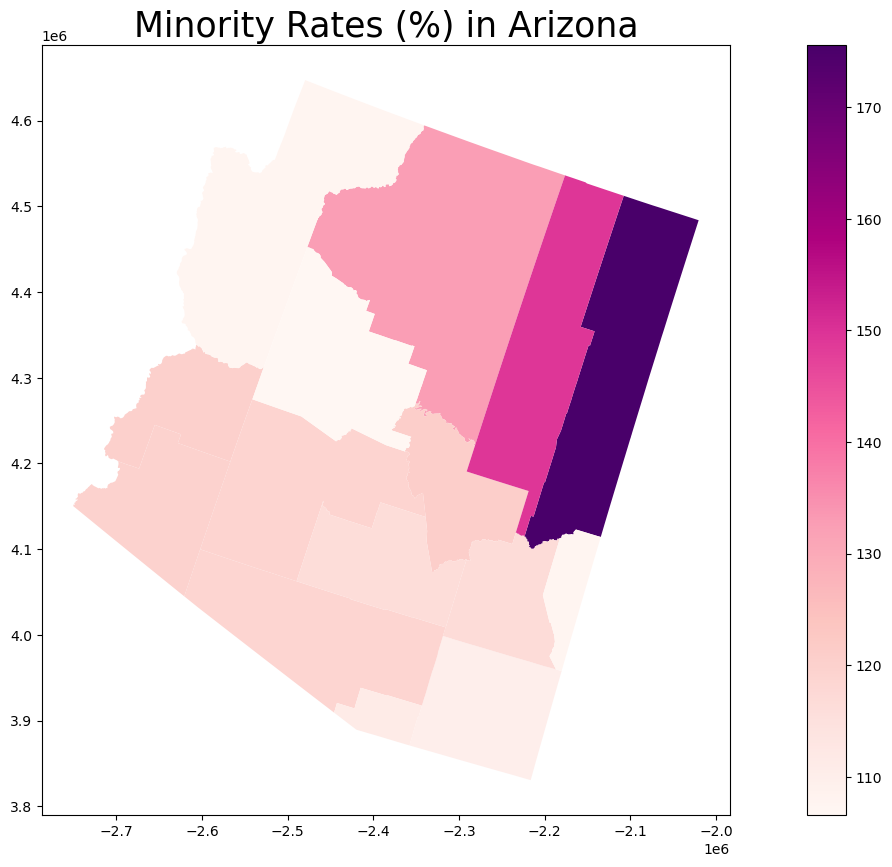

In [14]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
az_poverty_county.plot(column = "Minority_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Minority Rates (%) in Arizona', fontdict = {'fontsize': '25', 'fontweight' : '3'})